<div style="text-align: center;">
    <h1>NLP EDA U1997397</h1>
</div>
### 1. Important libraries 

In [1]:
import pandas as pd # For handling data frames and performing structured data opreations. 
from tabulate import tabulate # For printing tabular data is a readable, markdown-stylee format.
import numpy as np # For numerical operations, arrays, and matrix manipulation.
import os
import matplotlib # Core plotting library.
import matplotlib.pyplot as plt # For creating static plots (e.g., bar,line,scatter).
import matplotlib.patches as mpatches # For drawing custom shapes in plots.
import seaborn as sns # For enhanced, beautiful statistical plots built on top of matplotlib.
from matplotlib.ticker import FuncFormatter
from nltk.corpus import stopwords #Provides tools like stopword removal, tokenization, and n-grams.
from nltk.util import ngrams
import nltk
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud # Visualize word frequency uising a cloud of text.

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  # Transfoorm text to numeric feature vectors.
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD # Dimensionality reduction techniques.
from sklearn.metrics import classification_report,confusion_matrix # Evaluate model performance.

from collections import defaultdict # Dictionary with default values.
from collections import Counter # Count frequency of elements (e.g., words in a document).
plt.style.use('ggplot')
stop=set(stopwords.words('english'))

import re # Regular expressions for pattern-based text cleaning. 
from nltk.tokenize import word_tokenize
import gensim # Used for advanced NLP models like Word2Vec, LDA topic modeling. 
from gensim.utils import simple_preprocess
from gensim import corpora
import string # Basic string operations and punctuation removal.
from gensim.models import LdaModel
import pyLDAvis.gensim_models
import pyLDAvis
from gensim.models.coherencemodel import CoherenceModel

from tqdm import tqdm  # Display progress bars for loops and processes.
# Deep learning with TensoorFlow (Keras API)
from tensorflow.keras.preprocessing.text import Tokenizer # Prepare sequences for model input 
from tensorflow.keras.preprocessing.sequence import pad_sequences # Pad sequences for model input.
from tensorflow.keras.models import Sequential # Build a sequential neural network model.
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout # Define neural network layers for NLP.
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam # Popular optimizer for traioning neural networks.
import pyLDAvis
import pyLDAvis.gensim_models  

import torch
import warnings
warnings.simplefilter('ignore')


import torch

import warnings
warnings.simplefilter('ignore')

<frozen importlib._bootstrap>:488: DeprecationWarning: Type google.protobuf.pyext._message.ScalarMapContainer uses PyType_Spec with a metaclass that has custom tp_new. This is deprecated and will no longer be allowed in Python 3.14.
<frozen importlib._bootstrap>:488: DeprecationWarning: Type google.protobuf.pyext._message.MessageMapContainer uses PyType_Spec with a metaclass that has custom tp_new. This is deprecated and will no longer be allowed in Python 3.14.


In [2]:
# The information for columns
def inspect_df (df, name):
    info_df = pd.DataFrame({
        "Column":   df.columns,
        "Dtype":    df.dtypes.values,
        "Non-null": df.notnull().sum().values,
        "Null":     df.isnull().sum().values  
    })
    # Print structure of rows and columns
    print(f"\n=== {name} ===")
    print(f"Shape: {df.shape[0]} rows × {df.shape[1]} cols")
    print(tabulate(info_df, headers= "keys", tablefmt="psql", showindex=False))
    
df_train = pd.read_csv("train.csv",header = None, names = ["class", "title", "text"])
df_test  = pd.read_csv("test.csv",header = None, names = ["class", "title", "text"])

# Comparison 
inspect_df(df_train, "Train")
inspect_df(df_test, "Test")
    



=== Train ===
Shape: 3600000 rows × 3 cols
+----------+---------+------------+--------+
| Column   | Dtype   |   Non-null |   Null |
|----------+---------+------------+--------|
| class    | int64   |    3600000 |      0 |
| title    | object  |    3599793 |    207 |
| text     | object  |    3600000 |      0 |
+----------+---------+------------+--------+

=== Test ===
Shape: 400000 rows × 3 cols
+----------+---------+------------+--------+
| Column   | Dtype   |   Non-null |   Null |
|----------+---------+------------+--------|
| class    | int64   |     400000 |      0 |
| title    | object  |     399976 |     24 |
| text     | object  |     400000 |      0 |
+----------+---------+------------+--------+


Check the Class distribution 

In [20]:
df_train.head(10)


,class,title,text
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
5,2,an absolute masterpiece,I am quite sure any of you actually taking the...
6,1,Buyer beware,"This is a self-published book, and if you want..."
7,2,Glorious story,I loved Whisper of the wicked saints. The stor...
8,2,A FIVE STAR BOOK,I just finished reading Whisper of the Wicked ...
9,2,Whispers of the Wicked Saints,This was a easy to read book that made me want...


### Class distribution

### Sentiment Class Distribution 
To understand the structure of the training set, we first conducted an EDA on the sentiment labels. The dataset includes two sentiment classes: From introduction of the dataset

· Class 1: Negative reviews

· Class 2: Positive reviews

The following bar chart shows the distribution of sentiment labels in the training set: 
From the chart, we observe that each class contains 1,800,800 reviews, which means the dataset is a balanced dataset. This ideal for classification tasks, as a balanced class distribution helps prevent bias toward one class during training. 

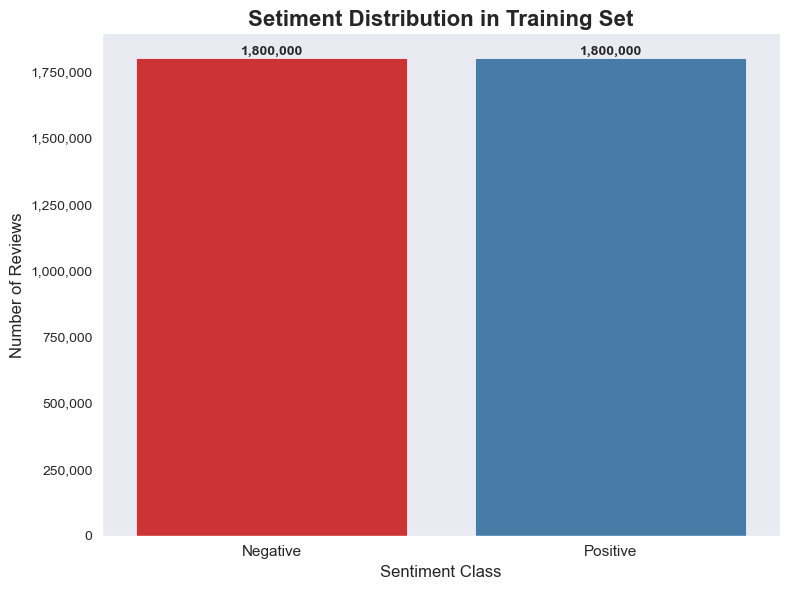

In [3]:
# Set the visual style 
sns.set_style('dark')
plt.figure(figsize= (8,6))

# Draw the count plot for sentiment classes
ax = sns.countplot(data = df_train, x = 'class', palette= 'Set1')

# Set title and axis labels 
plt.title ('Setiment Distribution in Training Set', fontsize = 16, fontweight = 'bold')
plt.xlabel("Sentiment Class", fontsize = 12)
plt.ylabel('Number of Reviews', fontsize = 12)


# Rename x-axis ticks labels for better interpretation 
ax.set_xticklabels(['Negative', 'Positive'] , fontsize = 11)

# Format y-axis ticks with thousands separator (e.g., 1,800,000)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))

# Add count labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height):,}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, fontweight='bold')
sns.despine()
plt.tight_layout()
plt.show()



###  Number of characters in training set
This plot compares the distribution of review lengths (in characters) between negative (class 1) and positive (class 2) Amazon reviews. It helps us understand whether review length varies significantly across sentiment classes.

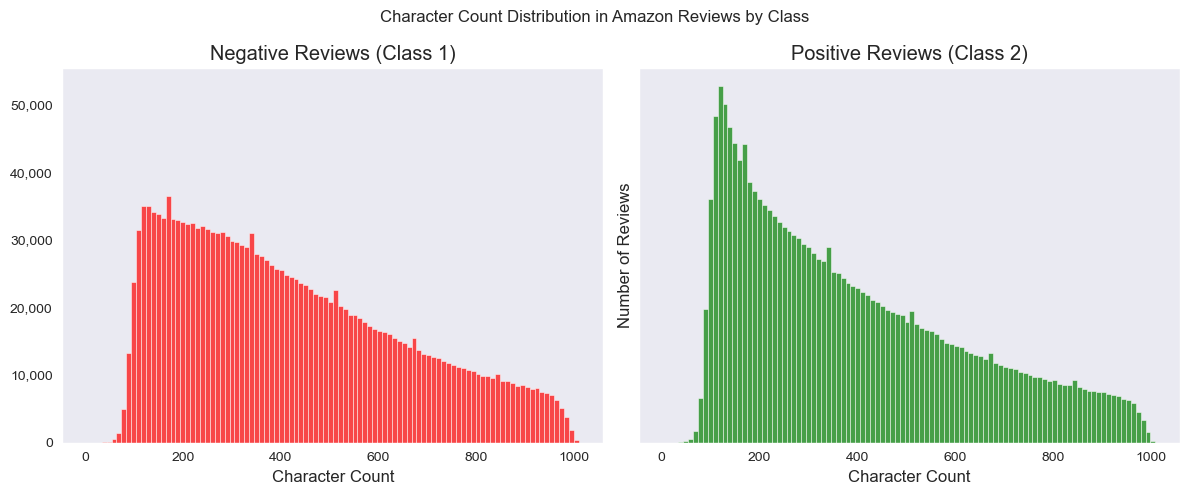

In [4]:
# Function to calculate length of each review
def get_length(text):
    return len(text)

# Create a new column 'length' in training set
df_train['length'] = df_train['text'].apply(get_length)

# Create two subsets for plotting
negative_reviews= df_train[df_train['class'] == 1]['length']
positive_reviews= df_train[df_train['class'] == 2]['length']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
thousands_fmt = FuncFormatter(lambda x, p: f'{int(x):,}')

# Plot histogram for positive reviews
ax2.hist(positive_reviews, bins=100, color='green', alpha=0.7)
ax2.set_title('Positive Reviews (Class 2)')
ax2.set_xlabel('Character Count')
ax2.set_ylabel('Number of Reviews')
ax2.yaxis.set_major_formatter(thousands_fmt)
# Plot histogram for negative reviews
ax1.hist(negative_reviews, bins=100, color='red', alpha=0.7)
ax1.set_title('Negative Reviews (Class 1)')
ax1.set_xlabel('Character Count')
ax1.yaxis.set_major_formatter(thousands_fmt)

# Add overall title
fig.suptitle('Character Count Distribution in Amazon Reviews by Class')
plt.tight_layout()
plt.show()


# Analysis of Character Count Distribution in Training Set 

### 1. Right-skewed Distribution

Both negative (Class 1) and negative (Class 2) reviews exhibit a right-skewed distribution. The majority of reviews are relatively short, typically ranging between 150 and 350 characters, while long reviews are rare.

### 2. Frequency Observation 

Although the shape of both distributions is quite similar, positive reviews tend to be slightly more frequent in the peak region than negative ones, suggesting users may write slightly shorter texts when expressing satisfaction.

### 3. Presence of Outliers

Both classes include a small number of very long reviews (exceeding 800 characters), which may be considered outliers and could need special treatment during preprocessing.
   

# Word count 

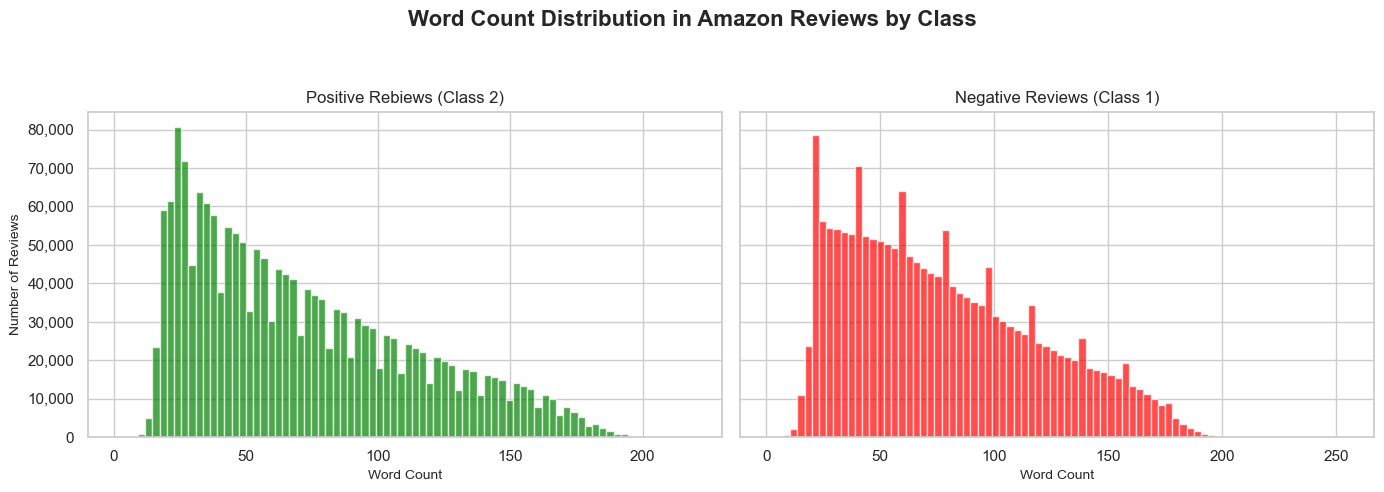

In [6]:
# Use Seaborn's built-in theme (white + grid)
sns.set_theme(style = "whitegrid")

# Compute word counts
df_train['word_count'] = df_train['text'].astype(str).apply(lambda s : len(s.split()))

# Split into two classes 
positive = df_train[df_train['class'] == 2]['word_count']
negative = df_train[df_train['class'] == 1]['word_count']

fig,(ax1,ax2) = plt.subplots(1, 2, figsize = (14,5), sharey = True)
fig.suptitle('Word Count Distribution in Amazon Reviews by Class', fontsize = 16, fontweight ='bold')

# Thousands-separator formatter
fmt = FuncFormatter(lambda x,_:f"{int(x):,}")

# Plot Positive Reviews 
ax1.hist(positive, bins = 80, color = 'green', alpha = 0.7)
ax1.set_title('Positive Rebiews (Class 2)', fontsize = 12)
ax1.set_xlabel('Word Count', fontsize = 10)
ax1.set_ylabel('Number of Reviews', fontsize = 10)
ax1.yaxis.set_major_formatter(fmt)

# Plot Negative Reviews
ax2.hist(negative,bins = 80, color ='red',alpha = 0.7)
ax2.set_title('Negative Reviews (Class 1)', fontsize = 12)
ax2.set_xlabel('Word Count', fontsize = 10)
ax2.yaxis.set_major_formatter

plt.tight_layout(rect=[0,0,1,0.93])
plt.show()

### Average average word count by class


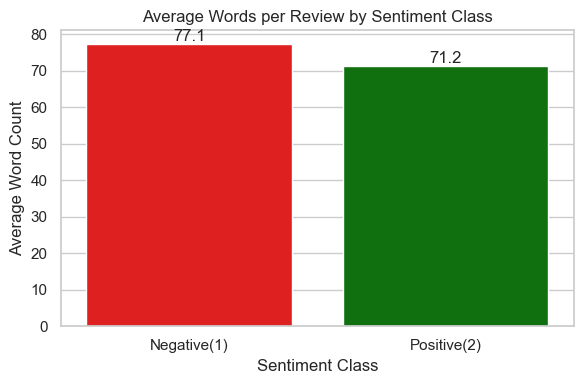

In [7]:
# Make sure you have word counts: 
mean_counts = df_train.groupby('class')['word_count']\
    .mean()\
        .reset_index()

# Plot the averages 
plt.figure(figsize = (6,4))
ax = sns.barplot(
    data = mean_counts,
    x='class',
    y='word_count',
    palette=['red','green']
)

ax.set_xticklabels(['Negative(1)', 'Positive(2)'])
ax.set_xlabel('Sentiment Class')
ax.set_ylabel('Average Word Count')
ax.set_title('Average Words per Review by Sentiment Class')

# Annotate bars with the numeric values (rounded)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}',
                (p.get_x() + p.get_width()/2, height),
                ha='center', va='bottom')
plt.tight_layout()
plt.show()        

### Common stopwords

{'in', 'until', 'we', 'ourselves', 'am', 'won', 'my', 'there', 'because', 'all', 'before', 'as', 'about', 'doesn', "won't", "we'd", 'his', 'don', 'which', "you've", 'o', 'on', 'few', 'these', 'what', 'them', "haven't", 'be', 'of', 'our', 'should', 'your', 'have', "wouldn't", 'themselves', 'can', 'ma', 'very', 'couldn', 'ours', "she'd", 're', 'was', 'herself', 'its', 'the', 'through', "hasn't", 'again', 'hers', 'for', 'been', 'yourselves', "that'll", "didn't", 'only', 'off', 'their', "isn't", 'an', 'did', 'where', "they've", 'yourself', "i've", 'under', 'when', 'wasn', 'll', 'it', 'any', 'just', 'doing', 'then', 'has', 'nor', 'too', "he's", 'himself', 'is', 'd', "it's", 'you', 'will', "they'd", "you're", 'below', "doesn't", 'to', 'now', 'hadn', 'at', 'up', "aren't", "you'd", 'if', 'isn', 't', 'each', 'yours', 'this', 'wouldn', 'between', 'myself', "it'll", 'here', "i'll", "mustn't", 'they', "we've", 'does', 'more', 'a', 'she', 'from', 'after', "hadn't", "you'll", 'how', 'most', 'by', 'a

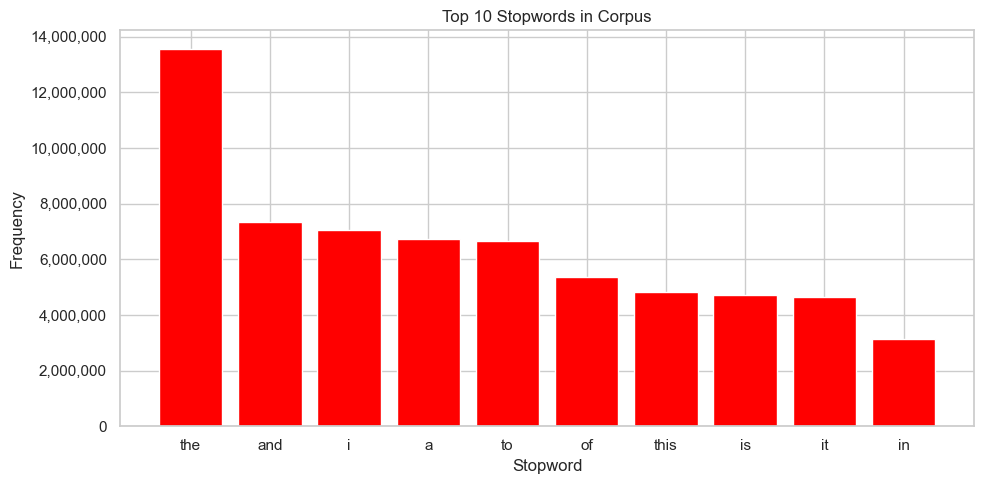

In [8]:
import nltk
from nltk.corpus import stopwords

# Load English stopwords
stop = set(stopwords.words('english'))

# Create corpus 
corpus =[]
for x in df_train['text'].astype(str).str.split():
    for i in x:
        corpus.append(i.lower())  # All of words are lower case

# Calculate the frequences of stopwords 
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1

# Frequency ranking (by descending)
top_stopwords = sorted(dic.items(), key = lambda x: x[1], reverse = True)
# Select top 10
top10 = top_stopwords [:10]

# The stopwords
found_stopwords = set (word for word in corpus if word in stop)
print(found_stopwords)
# Plot 
plt.figure(figsize = (10,5))
x,y = zip(*top10)
plt.bar(x,y,color = 'red')
plt.title("Top 10 Stopwords in Corpus")
plt.xlabel("Stopword")
plt.ylabel("Frequency")
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()


# Analyzing punctuations 

{'!"', '+,', '~', '$', '+', '=>', ')*', '-', '"#', '?', '<=>', ']', '/:', '^_', '-.', '/', '#', '`', '.', '\\', ',-', ')', ':', '|', '(', '*', '<', ';', '<=', '_', ',', './', '%', '^', '{', '@', '[', '>', "'(", '"', '#$%', '=', '}', '!', "'", '[\\]', '+,-', '#$%&', '&', '()'}


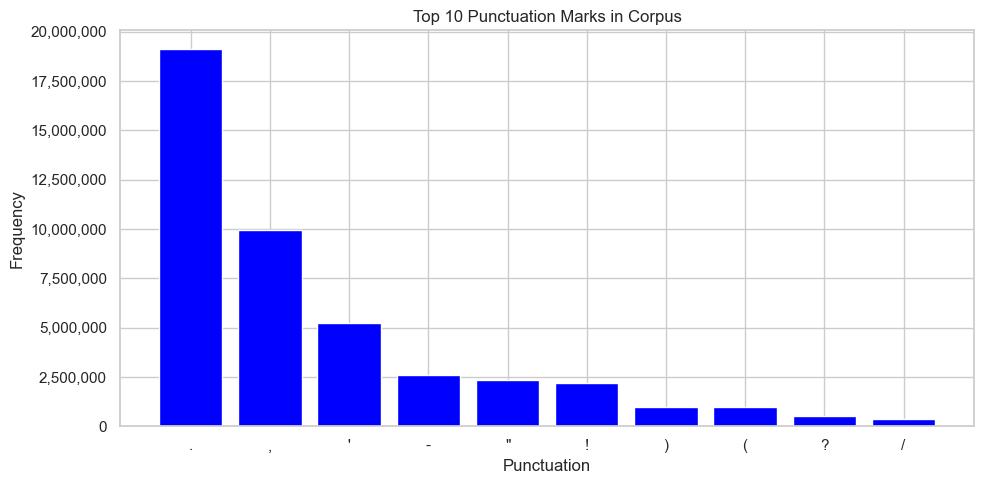

In [9]:
# Cropus function 
corpus1 = []
for x in df_train['text'].astype(str):
    for char in x: 
        corpus.append(char)

# Calculate the frequencies of punctuation marks
dic = defaultdict(int)
for char in corpus:
    if char in string.punctuation:
        dic[char] += 1

# Frequency ranking (by descending)
top_punct = sorted(dic.items(), key=lambda x: x[1], reverse = True)
# Select top 10
top10 = top_punct[:10]

# The punctuation symbols found 
found_punct = set(char for char in corpus if char in string.punctuation)
print(found_punct)

# Plot 
plt.figure(figsize = (10, 5))
x, y =zip(*top10)
plt.bar(x,y, color = 'blue')
plt.title("Top 10 Punctuation Marks in Corpus")
plt.xlabel("Punctuation")
plt.ylabel("Frequency")
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()



### N-gram analysis

We will do a bigram (n=2) analysis over the Amazon dataset

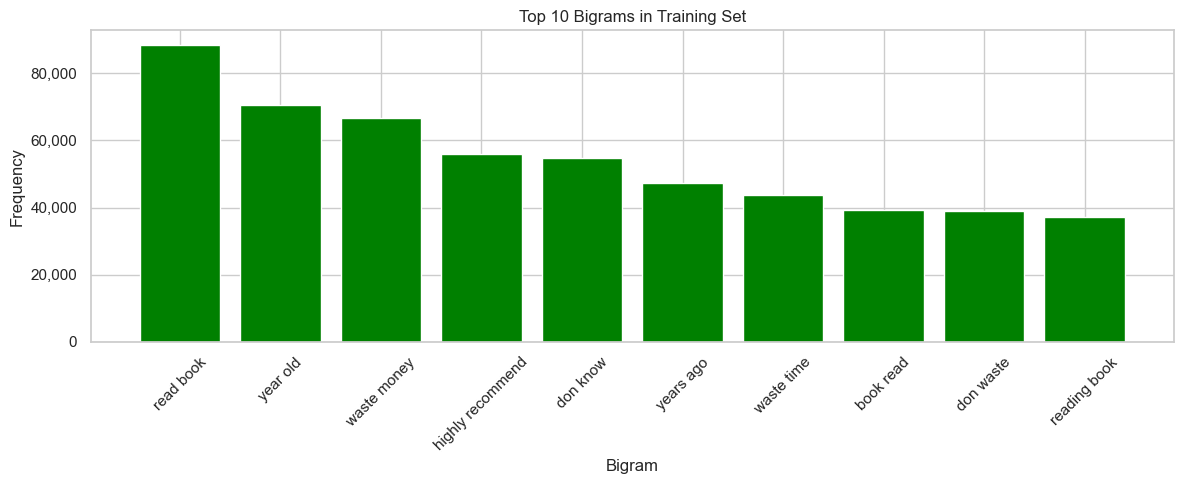

In [10]:
# Initialize a CountVectorizer with bigram (n=2)
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')

# Fit and transform the training text data
X = vectorizer.fit_transform(df_train['text'].astype(str))

# Sum the frequencies of each bigram
sum_words = X.sum(axis=0)
bigram_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]

# Sort bigrams by frequency
sorted_bigrams = sorted(bigram_freq, key=lambda x: x[1], reverse=True)

# Select top 10
top10 = sorted_bigrams[:10]

x, y = zip(*top10)
plt.figure(figsize=(12, 5))
bars = plt.bar(x, y, color='green')
plt.title("Top 10 Bigrams in Training Set")
plt.xlabel("Bigram")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))


plt.tight_layout()
plt.show()


# Data Cleaning

Before applying topic modelling techniques such as LDA and BERTopic, it is essential to clean the Amazon review texts. Raw customer reviews often contain noise, such as stop words, punctuation, repeated characters, and other non-informative tokens, which may obscure the underlying semantic patterns. Proper cleaning ensures that the data fed into the models consists primarily of meaningful words, enabling more accurate identification of latent topics. Additionally, techniques such as removing punctuation, removing stopwords, and lemmatization help standardize the text and reduce sparsity, thereby improving both the quality and interpretability of the extracted topics.   

In [3]:
df_train ["source"]  = "train"
df_test["source"] = "test"
df = pd.concat ([df_train,df_test], ignore_index= True)
clean_df = df.copy()

#
df_train_clean = clean_df[clean_df["source"] == "train"]. drop("source", axis = 1)
df_test_clean = clean_df[clean_df["source"] == "test"]. drop ("source" , axis =1)

In [4]:
# Merge "title' and 'text' into new column 'full text'
# Fill missing titles/texts with empty string before concatenation 
clean_df["full_text"] = clean_df["title"].fillna("") + " " + clean_df["text"].fillna("")

# Normalize text by converting to lowercase and stripping extra whitespace
clean_df["clean_text"] = clean_df["full_text"].str.lower().str.strip()

# Preview the result to ensure the transformation is correct.
clean_df[["full_text", "clean_text"]].head(3)


,full_text,clean_text
0,Stuning even for the non-gamer This sound trac...,stuning even for the non-gamer this sound trac...
1,The best soundtrack ever to anything. I'm read...,the best soundtrack ever to anything. i'm read...
2,Amazing! This soundtrack is my favorite music ...,amazing! this soundtrack is my favorite music ...


### Remove punctuation

In [5]:
# Remove all punctuation characters from cleaned 
# Create a translation table that maps each punctuation character to None 
punct_translator = str.maketrans("","", string.punctuation)
# Apply the translation to each entry in 'clean_text'
clean_df["clean_text"] = clean_df["clean_text"].apply(lambda txt: txt.translate(punct_translator))
# Preview the first few cleaned sentences
print(clean_df["clean_text"].head(3))

0    stuning even for the nongamer this sound track...
1    the best soundtrack ever to anything im readin...
2    amazing this soundtrack is my favorite music o...
Name: clean_text, dtype: object


### Lemmatization

In [6]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatize_sentence(sentence):
    tokens = sentence.split()  # split into tokens
    lemmatized_tokens = [lemmatizer.lemmatize(tok) for tok in tokens]
    return " ".join(lemmatized_tokens) 

# Apply lemmatization to the 'clean_text' column
clean_df["clean_text"] = clean_df["clean_text"].apply(lemmatize_sentence)

# Preview the first few lemmatized sentences
print(clean_df["clean_text"].head(3))

0    stuning even for the nongamer this sound track...
1    the best soundtrack ever to anything im readin...
2    amazing this soundtrack is my favorite music o...
Name: clean_text, dtype: object


### Remove stop words

In [ ]:
# Now, we load English stopwords set
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    """
    Remove common English stopwords from the sentence
    """
    tokens = text.split()
    filered_tokens = [word for word in tokens if word not in stop_words]
    return " ".join(filered_tokens)

# Apply stopword removal to the 'clean_text'
clean_df["clean_text"] = clean_df["clean_text"].apply(remove_stopwords) 

# Preview the result after stopword removal 
print(clean_df["clean_text"].head(3))   

0    stuning even nongamer sound track wa beautiful...
1    best soundtrack ever anything im reading lot r...
2    amazing soundtrack favorite music time hand in...
Name: clean_text, dtype: object


### Split the cleaned DataFrame back into train and test sets

In [ ]:
# Filter out training data, drop unnecessary columns, and rest index
df_train_clean = clean_df[clean_df["source"] == "train"]\
    .drop(["source","full_text","title","text"], axis=1) \
        .reset_index(drop = True)

# Filter out test data, drop unnecessary columns, and reset index
df_test_clean = clean_df[clean_df["source"] == "test"] \
    .drop(["source", "full_text", "title", "text"], axis=1) \
    .reset_index(drop=True)
    
print("Train shape:", df_train_clean.shape)
print("Test shape:", df_test_clean.shape)
print(df_train_clean.head(3))

Train shape: (3600000, 2)
Test shape: (400000, 2)
   class                                         clean_text
0      2  stuning even nongamer sound track wa beautiful...
1      2  best soundtrack ever anything im reading lot r...
2      2  amazing soundtrack favorite music time hand in...


After completing the data cleaning process, the review texts are now standardized and stripped of of non-informative elements. Specifically, the cleaning involved merging titles and texts into a single field, normalizaing the text by lowercasing and trimming whitespace, removing punctuation and common stop words, and applying lemmatization to reduce words to their base forms. These steps ensure that the textualdata mainly consists of meaningful tokens, which is crucial for uncovering latent semantic structures. With this refined and noise-free corpus, we can now proceed to topic modeling techniques, such as LDA and BERTopic, to identify and interpret the underlying topics within the Amazon reviews.

# Topic modelling 

### Motivation and Assumption
Traditional text classification methods rely on labeled data, which is expensive and time-consuming to obtain for a large document collections. We will meet many scenarios in real-world, which given our text are unlabeled, but we still need to explore the hidden semantic structure or organize the documents based on underlying topics. 

Latent Dirichlet Allocation (LDA) provides a solution by offering an unsupervised probabilistic framework that help us automatically develops abstract topics in a corpus. Unlike simpe frequencey methods (e.g., TF-IDF) or matrix factorization approaches. LDA models each document as a mixture of latent topics and each topic as a distribution over words, which improves semantic interpretability and generalizes better to unseen documents. 

Since the original dataset (Amazon) is very large and LDA is computationally expensive, we randomly selected 1,000 positive and 1,000 negative reviews (balanced smamples) for topic modeling analysis, which allows us to reduce computational cost and explore whether the semantic structure differs significantly between positive and negative review.


### Randomly sample 1,000 positive and 1,000 negative reviews
In this task, the first step is to randomly select a collection of 1,000 negative reviews and 1,000 positive reviews from sentiment analysis dataset. 

In [ ]:
# Separate positive and negative reviews (from EDA we have class 2 = 'positive', class 1 = 'negative')
positive_reviews = df_train_clean[df_train_clean["class"] == 2]
negative_reviews = df_train_clean[df_train_clean["class"] == 1]

# Randomly sample 1,000 from each class (set random_state for reporducibility)
sample_positive = positive_reviews.sample(n=1000, random_state= 42)
sample_negative = negative_reviews.sample(n=1000, random_state= 42)



The analysis will begin with the negative reviews. The text will be preprocessed by performing tokenization and constructing a dictionary, which can filtered out rare words and overly frequent words. This step can improve topic quality. 

### Tokenization for negative reviews and build dictionary

Before fitting the LDA model, the text need to be converted into a numerical representation that the algorithm can process. Specifically, we perform tokenization to split each review into a list of meaningful words, followed by construction of a dictionary that maps each unique word to an integer ID.

To improve the quality of the generated topics, we apply a filtering step to remove:

· Rare words (appearing in fewer than 10 documents), which may introduce noise, and 

· Overly frequent words (appearing in more than 80% of documents), which often lack discriminative power.

Finally, we create a Bag-of-Words (BoW) corpus, where each review is represented as a list of tuples (word_id, frequency). This structured format is required for LDA, which models the probability distribution of words over topics. 

In [ ]:

# Tokenization for negative review
tokenized_neg = sample_negative['clean_text']. apply(lambda x : simple_preprocess(x,deacc = True))

# Build dictionary = corpora.Dictionary (tokenized_neg)
dictionary_neg = corpora.Dictionary(tokenized_neg)

# Filter extreme (optional, improves topic quality)
dictionary_neg.filter_extremes(no_below = 10, no_above = 0.8)

# Create Bag-of-Word (BoW) corpus  
corpus_neg = [dictionary_neg.doc2bow(text) for text in tokenized_neg]

print("Simple tokens (negative):", tokenized_neg.iloc[0][:15])
print("Dictionary size (negative):", len(dictionary_neg))

Simple tokens (negative): ['history', 'torture', 'execution', 'yet', 'received', 'book', 'ordered', 'even', 'though', 'paid', 'rather', 'high', 'price', 'unable', 'get']
Dictionary size (negative): 688


In [ ]:
# 1. Check how many tokenized docs are non-empty
valid_count = sum(1 for tokens in tokenized_neg if len(tokens) > 0)
print(f"Non-empty tokenized docs: {valid_count}/{len(tokenized_neg)}")

# 2. Check dictionary size before filtering
dictionary_neg_raw = corpora.Dictionary(tokenized_neg)
print("Raw dictionary size (before filtering):", len(dictionary_neg_raw))

Non-empty tokenized docs: 1000/1000
Raw dictionary size (before filtering): 8711


In [ ]:
print(dictionary_neg.token2id)


{'beginning': 0, 'book': 1, 'even': 2, 'get': 3, 'high': 4, 'history': 5, 'less': 6, 'may': 7, 'ordered': 8, 'paid': 9, 'price': 10, 'rather': 11, 'received': 12, 'seller': 13, 'something': 14, 'star': 15, 'think': 16, 'though': 17, 'yet': 18, 'zero': 19, 'black': 20, 'care': 21, 'described': 22, 'direction': 23, 'disappointed': 24, 'first': 25, 'ha': 26, 'handle': 27, 'however': 28, 'mean': 29, 'month': 30, 'much': 31, 'nearly': 32, 'offer': 33, 'product': 34, 'really': 35, 'see': 36, 'set': 37, 'shouldnt': 38, 'show': 39, 'soon': 40, 'started': 41, 'used': 42, 'user': 43, 'using': 44, 'wa': 45, 'wrong': 46, 'another': 47, 'enjoy': 48, 'fall': 49, 'film': 50, 'movie': 51, 'need': 52, 'one': 53, 'say': 54, 'thought': 55, 'video': 56, 'wanted': 57, 'weak': 58, 'would': 59, 'awful': 60, 'boy': 61, 'career': 62, 'glad': 63, 'library': 64, 'page': 65, 'plain': 66, 'simply': 67, 'spend': 68, 'story': 69, 'better': 70, 'cup': 71, 'end': 72, 'ever': 73, 'go': 74, 'hard': 75, 'new': 76, 'opini

In [ ]:
print(corpus_neg[0])


[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1)]


In [ ]:
[[dictionary_neg[id], freq] for id, freq in corpus_neg[0]]


[['beginning', 1],
 ['book', 1],
 ['even', 1],
 ['get', 1],
 ['high', 1],
 ['history', 1],
 ['less', 1],
 ['may', 1],
 ['ordered', 1],
 ['paid', 1],
 ['price', 1],
 ['rather', 1],
 ['received', 1],
 ['seller', 1],
 ['something', 1],
 ['star', 1],
 ['think', 1],
 ['though', 1],
 ['yet', 1],
 ['zero', 1]]

The tokenization process successfully converted all 1,000 negative reviews into lists of meaningful tokens. The initial dictionary contained 8,711 unique words, reflecting the high lexical diversity of raw reviews. After applying frequency-based filtering (no_below = 10, no_above = 0.8) the dictionary size was reduced to 688 words, which helps remove noisy rare terms and overly frequent, non-informative words. This dimensionality reduction is crucial for LDA, as it improves both computational efficiency and topic quality by focusing on semantically relevant tokens.  

### Train LDA on negative corpus


The LDA model was trained on the negative review corpus using 10 topics. The key parameters include passes = 10 for iterative refinement, alpha = 'auto' for adaptive topic sparsity, and per_word_topics = True to estimate topic distributions at the word level. The output shows the top 10 most representative words for each topic. For instance, terms such as 'book', 'movie', and 'DVD' dominate certain topics, indicating that negative reviews are often related to entertainment products, while words like 'wa', 'like', 'buy' are more general and appear across multiple topics. The intertopic distance map (via multidimensional scaling) helps visualize the relationships between topics: 

· Well-separated bubles (e.g, Topics 5 and 7) indicate distinct semantic clusters.

· Overlapping or closely positioned bubbles (e.g., Topics 3 and 9) suggest semantic similarity or insufficient topic separation. 

The bar chart of the most salient terms shows that frequent terms like 'book' and 'movie' dominate the overall corpus, which may influence multiple topics. The model generally captures meaningful patterns in negative reviews, though some topics may still overlap semantically. 

In [64]:
import pyLDAvis.gensim_models

lda_neg = LdaModel(
    corpus = corpus_neg,
    id2word= dictionary_neg,
    num_topics= 10,
    random_state= 42,
    passes= 10,
    alpha='auto',
    per_word_topics= True
)

print ("Negative Reviews Topics:")
for idx, topic in lda_neg.print_topics (num_words = 10):
    print (f"Topic {idx}: {topic}")

pyLDAvis.enable_notebook ()
vis_neg  = pyLDAvis.gensim_models.prepare (lda_neg, corpus_neg, dictionary_neg)
vis_neg

Negative Reviews Topics:
Topic 0: 0.059*"wa" + 0.018*"time" + 0.017*"one" + 0.012*"would" + 0.011*"got" + 0.011*"get" + 0.010*"good" + 0.009*"read" + 0.009*"like" + 0.009*"review"
Topic 1: 0.032*"one" + 0.020*"product" + 0.016*"wa" + 0.012*"buy" + 0.012*"item" + 0.011*"get" + 0.011*"use" + 0.010*"year" + 0.010*"two" + 0.010*"work"
Topic 2: 0.029*"like" + 0.020*"dont" + 0.017*"wa" + 0.016*"really" + 0.015*"sound" + 0.014*"music" + 0.013*"much" + 0.013*"good" + 0.013*"get" + 0.012*"money"
Topic 3: 0.059*"movie" + 0.036*"wa" + 0.020*"dvd" + 0.017*"would" + 0.017*"film" + 0.015*"bad" + 0.014*"even" + 0.012*"one" + 0.011*"star" + 0.011*"ha"
Topic 4: 0.081*"wa" + 0.017*"time" + 0.014*"like" + 0.012*"disappointed" + 0.012*"first" + 0.012*"bought" + 0.012*"unit" + 0.011*"back" + 0.010*"character" + 0.010*"buy"
Topic 5: 0.038*"cd" + 0.025*"song" + 0.023*"like" + 0.023*"one" + 0.019*"ha" + 0.017*"get" + 0.014*"would" + 0.014*"dont" + 0.012*"track" + 0.011*"sound"
Topic 6: 0.046*"book" + 0.026*"a

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.132497 -0.102594       1        1  16.182874
3      0.052664  0.015388       2        1  12.492773
0     -0.015713 -0.048373       3        1  11.010509
1     -0.077650  0.012268       4        1  10.591066
7     -0.165975 -0.027703       5        1  10.237850
2      0.033116  0.073665       6        1  10.209091
5      0.038228  0.153525       7        1   7.569907
6      0.115604 -0.013469       8        1   7.485659
4     -0.013565 -0.053652       9        1   7.262126
8     -0.099206 -0.009054      10        1   6.958144, topic_info=      Term        Freq       Total Category  logprob  loglift
1     book  613.000000  613.000000  Default  30.0000  30.0000
51   movie  191.000000  191.000000  Default  29.0000  29.0000
45      wa  801.000000  801.000000  Default  28.0000  28.0000
445     cd   97.000000   97.000000  Default  27.0000  27.0000
296  album   83.000000   83.000000  Default  26.0000  26.0000
..     ...         ...         ...      ...      ...      ...
2     even   14.066079  164.463492  Topic10  -4.8281   0.2063
161   dont   15.184132  240.242604  Topic10  -4.7516  -0.0961
256   make   13.049862  132.836880  Topic10  -4.9031   0.3449
110   like   14.946540  285.474218  Topic10  -4.7674  -0.2844
146    bad   12.827278  130.357007  Topic10  -4.9203   0.3466

[601 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
312       1  0.193207  absolutely
312       3  0.257609  absolutely
312       4  0.386413  absolutely
312      10  0.064402  absolutely
331       2  0.949802      acting
...     ...       ...         ...
144       9  0.075139        year
144      10  0.064405        year
19        2  0.783422        zero
19        5  0.060263        zero
19        6  0.120526        zero

[2323 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 4, 1, 2, 8, 3, 6, 7, 5, 9])

Simirly, we model positive reviews

### Tokenization for positive reviews and build dictionary

Similarly as negative reviews, all 1,000 positive reviews were successfully split into meaningful token lists (Non-empty tokenized docs: 1,000/1000). The initial dictionary contained 8,888 unique words, reflecting the rich diversity of customer languge.

In [16]:

# Tokenization for negative review
tokenized_pos = sample_positive['clean_text']. apply(lambda x : simple_preprocess(x,deacc = True))

# Build dictionary = corpora.Dictionary (tokenized_neg)
dictionary_pos = corpora.Dictionary(tokenized_pos)

# Filter extreme (optional, improves topic quality)
dictionary_pos.filter_extremes(no_below = 10, no_above = 0.8)

# Create Bag-of-Word (BoW) corpus
corpus_pos = [dictionary_pos.doc2bow(text) for text in tokenized_pos]

print("Simple tokens (positive:", tokenized_pos.iloc[0][:15])
print("Dictionary size (positive):", len(dictionary_pos))


Simple tokens (positive: ['perfect', 'mantra', 'ive', 'looking', 'mantra', 'long', 'time', 'child', 'yoga', 'glad', 'lotus', 'mantra', 'making', 'class', 'enjoyable']
Dictionary size (positive): 617


In [17]:
# 1. Check how many tokenized docs are non-empty
valid_count = sum(1 for tokens in tokenized_pos if len(tokens) > 0)
print(f"Non-empty tokenized docs: {valid_count}/{len(tokenized_pos)}")

# 2. Check dictionary size before filtering
dictionary_pos_raw = corpora.Dictionary(tokenized_pos)
print("Raw dictionary size (before filtering):", len(dictionary_pos_raw))

Non-empty tokenized docs: 1000/1000
Raw dictionary size (before filtering): 8888


In [19]:
print(dictionary_pos.token2id)

{'adult': 0, 'back': 1, 'child': 2, 'class': 3, 'enjoyable': 4, 'even': 5, 'glad': 6, 'going': 7, 'ive': 8, 'long': 9, 'looking': 10, 'making': 11, 'perfect': 12, 'recommended': 13, 'time': 14, 'case': 15, 'im': 16, 'little': 17, 'metal': 18, 'photo': 19, 'quality': 20, 'saw': 21, 'thing': 22, 'wa': 23, 'big': 24, 'character': 25, 'find': 26, 'ha': 27, 'insight': 28, 'main': 29, 'mystery': 30, 'novel': 31, 'one': 32, 'pick': 33, 'true': 34, 'well': 35, 'ago': 36, 'anyone': 37, 'book': 38, 'condition': 39, 'entertaining': 40, 'face': 41, 'feeling': 42, 'get': 43, 'getting': 44, 'gone': 45, 'honest': 46, 'human': 47, 'know': 48, 'mean': 49, 'never': 50, 'question': 51, 'read': 52, 'really': 53, 'sure': 54, 'understand': 55, 'understanding': 56, 'value': 57, 'wanted': 58, 'wonderful': 59, 'written': 60, 'year': 61, 'youll': 62, 'another': 63, 'best': 64, 'bought': 65, 'clean': 66, 'easy': 67, 'ever': 68, 'food': 69, 'isnt': 70, 'like': 71, 'love': 72, 'make': 73, 'tell': 74, 'use': 75, 'c

In [20]:
print(corpus_pos[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1)]


Each review is represented as a list of (word_list, frequency) pairs - for example, the first review yields ('adult', 1), ('back', 1), ...,('time',1), confirming correct mapping.

In [18]:
[[dictionary_pos[id], freq] for id, freq in corpus_pos[0]]

[['adult', 1],
 ['back', 1],
 ['child', 1],
 ['class', 1],
 ['enjoyable', 1],
 ['even', 1],
 ['glad', 1],
 ['going', 1],
 ['ive', 1],
 ['long', 1],
 ['looking', 1],
 ['making', 1],
 ['perfect', 1],
 ['recommended', 1],
 ['time', 1]]

###  Train LDA on positive reviews

We trained an LDA model with 10 topics, passess = 10, alpha = 'auto', and per_word_topics = True. some sample topic highlights: 

· Topic 0: “great”, “good”, “wa”, “would”, “fit” … — emphasizing overall product quality and user satisfaction.

· Topic 1: “wa”, “movie”, “book”, “great”, “first” … — often related to entertainment purchases.

· Topic 4: “book”, “read”, “would”, “recommend” … — classic “reading recommendation” theme.

· Topic 9: “great”, “one”, “use”, “price” … — focusing on value-for-money and ease of use.


Additionally, some topics (e.g., Topic 8) appear well separated, indicating distinct semantic clusters. Others (e.g., Topic 1,3,7) overlap or lie close together, suggesting shared high-frequency terms. What's more the bar chart shows that wods like "book", "wa", "music", and "great" dominate positive reviews overall. Comparing opverall term frequency (blue) with topic-specific relevance (red) reveals which words are most characteristic of each topic.

In [68]:
lda_pos = LdaModel(
    corpus = corpus_pos,
    id2word= dictionary_pos,
    num_topics= 10,
    random_state= 42,
    passes= 10,
    alpha='auto',
    per_word_topics= True
)

print ("Positive Reviews Topics:")
for idx, topic in lda_pos.print_topics (num_words = 10):
    print (f"Topic {idx}: {topic}")

pyLDAvis.enable_notebook ()
vis_pos  = pyLDAvis.gensim_models.prepare (lda_pos, corpus_pos, dictionary_pos)
vis_pos

Positive Reviews Topics:
Topic 0: 0.027*"great" + 0.020*"good" + 0.019*"wa" + 0.018*"would" + 0.018*"fit" + 0.017*"one" + 0.016*"even" + 0.015*"best" + 0.014*"also" + 0.014*"little"
Topic 1: 0.068*"wa" + 0.025*"movie" + 0.024*"book" + 0.014*"great" + 0.013*"first" + 0.012*"one" + 0.012*"time" + 0.011*"see" + 0.011*"well" + 0.010*"read"
Topic 2: 0.047*"album" + 0.023*"great" + 0.020*"like" + 0.017*"time" + 0.017*"good" + 0.016*"wa" + 0.016*"work" + 0.015*"get" + 0.012*"music" + 0.012*"song"
Topic 3: 0.035*"great" + 0.034*"movie" + 0.024*"one" + 0.018*"film" + 0.017*"use" + 0.015*"easy" + 0.015*"good" + 0.014*"product" + 0.014*"would" + 0.014*"really"
Topic 4: 0.105*"book" + 0.036*"read" + 0.023*"story" + 0.016*"ha" + 0.015*"life" + 0.014*"get" + 0.013*"well" + 0.013*"one" + 0.011*"reading" + 0.011*"good"
Topic 5: 0.047*"game" + 0.024*"love" + 0.024*"one" + 0.020*"like" + 0.019*"video" + 0.017*"great" + 0.016*"wa" + 0.015*"child" + 0.015*"good" + 0.015*"old"
Topic 6: 0.050*"cd" + 0.034*"

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.072080 -0.006105       1        1  15.467148
4     -0.175773  0.073438       2        1  14.743473
8     -0.039660  0.043507       3        1  11.703427
2      0.044431  0.064364       4        1  10.497338
9      0.036823 -0.076382       5        1  10.422022
3      0.034060 -0.113900       6        1   8.755008
5     -0.037408 -0.016201       7        1   8.695666
6      0.139050  0.134026       8        1   8.609120
0      0.075919 -0.021743       9        1   6.664931
7     -0.005362 -0.081004      10        1   4.441866, topic_info=      Term        Freq       Total Category  logprob  loglift
38    book  572.000000  572.000000  Default  30.0000  30.0000
358   game   96.000000   96.000000  Default  29.0000  29.0000
184  album  149.000000  149.000000  Default  28.0000  28.0000
264     cd  138.000000  138.000000  Default  27.0000  27.0000
52    read  216.000000  216.000000  Default  26.0000  26.0000
..     ...         ...         ...      ...      ...      ...
23      wa   12.944243  504.581046  Topic10  -4.3539  -0.5490
71    like    8.579133  254.371707  Topic10  -4.7652  -0.2754
181   want    6.763242   92.164585  Topic10  -5.0030   0.5020
5     even    6.729637  104.791976  Topic10  -5.0080   0.3686
310   song    6.236932  112.429505  Topic10  -5.0840   0.2223

[596 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
266       1  0.582473   able
266       3  0.041605   able
266       4  0.124816   able
266       5  0.041605   able
266       7  0.166421   able
...     ...       ...    ...
377       3  0.132519  youre
377       4  0.344549  youre
377       5  0.132519  youre
377       9  0.106015  youre
377      10  0.079511  youre

[2243 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 9, 3, 10, 4, 6, 7, 1, 8])

LDA successfully uncovers coherent themes in positive reviews-such as product quality feedback, entertainment recommendations, and usability praise.

### Topic Coherence Evaluation 


After training the LDA models for both negative and positive reviews, the next step is to evaluate their quality. To assess how meaningful and interpretable the extracted topics are, we evaluate the Coherence Score (C_V). This metric measures the semantic similarity between the most relevent words within each topic, and higher scores generally indicate more coherent and human-interpretable topics. Here, we compute the baseline coherence scores for the standard LDA models (lda_neg and lda_pos) trained on negative and positive reviews. 

### 

### Baseline Coherence Scores

We compute the C_V coherence for both LDA models with  k = 10 topics using Gensim's coherenceModel. The output shows Negative reviews achieved a coherence of 0.4255, while positive reviews reached 0.3788. This confirms that the negative-review model yields slightly more semantically coherent topics at the chosen setting. 

In [ ]:
# Negative baseline
cm_neg = CoherenceModel(model = lda_neg,
                        texts = tokenized_neg,
                        dictionary = dictionary_neg,
                        coherence = 'c_v')
coh_neg = cm_neg.get_coherence()
print(f"Negative LDA coherence (C_V): {coh_neg:.4f}")

# Positive baseline 
cm_pos = CoherenceModel(model = lda_pos,
                        texts = tokenized_pos,
                        dictionary = dictionary_pos,
                        coherence = 'c_v')
coh_pos = cm_pos.get_coherence()
print(f"Positive LDA coherence (C_V):{coh_pos:4f}")



Negative LDA coherence (C_V): 0.4255
Positive LDA coherence (C_V):0.377800


### Tuning Number of Topics

Now, we defining a helper function tune_coherence to train LDA models over a range of topic counts (K = 2,3,4,..., 20) each with passes = 5 and alph = 'auto'. Fore each K, we record the C_V coherence, the plot "Number of Topics" vs. "Coherence (C_V)" for both corpora.

From below figure we can observe:

· Negative reviews (red circles) attain their peak coherence around K = 4 (approx = 0.45), then gradually decline as K increases. 

· Positive reviews (blue squares) show a more modest peak at K = 2 (approx = 0.384) and steadily lower coherence for larger K.

These suggest that a smaller number of topics captures the core themes more cleanly - especially for negative feedback- while too many topics can introduce noise and reduce semantic clarity. 

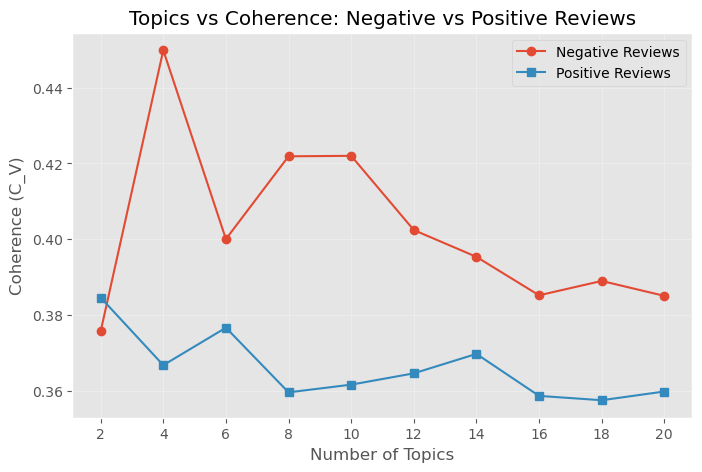

In [21]:
import matplotlib.pyplot as plt
from gensim.models import LdaModel

def tune_coherence(corpus, dictionary, texts, start=2, limit=10, step=2):
    ks, scores = [], []
    for k in range(start, limit+1, step):
        model = LdaModel(corpus=corpus, id2word=dictionary,
                         num_topics=k, random_state=42, passes=5, alpha='auto')
        cm = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        ks.append(k); scores.append(cm.get_coherence())
    return ks, scores
# 1. negative 
ks_neg, scores_neg = tune_coherence(corpus_neg, dictionary_neg, tokenized_neg,
                                    start=2, limit=20, step=2)
# 2. positive 
ks_pos, scores_pos = tune_coherence(corpus_pos, dictionary_pos, tokenized_pos,
                                    start=2, limit=20, step=2)

# Combined positive and negative reviews.
plt.figure(figsize=(8,5))
plt.plot(ks_neg, scores_neg, marker='o', label='Negative Reviews')
plt.plot(ks_pos, scores_pos, marker='s', label='Positive Reviews')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence (C_V)")
plt.title("Topics vs Coherence: Negative vs Positive Reviews")
plt.xticks(ks_neg)               
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Find the optimal number of topics (k)

The optimal number of topics (k) was determined by selecting the value of k that maximized the coherence score. The coherence score measures the semantic similarity of the top words within each topic, with higher scores indicating mnore interpretable and meaningful topics. Once the optimal identified find LDA models were retrained using these paramtere to ensure the best topic quality.

Based on these results, a 4-topic model is optimal for negative reviews, and 2 be best for positive reviews

In [22]:
# Find the optimal number of topics (k)
# Select the k (number of topics) that maximizes the coherence score.
# 'scores_neg'and 'scores_pos' are lists of coherence scores for different value
# 'ks_neg' and 'ks_pos' are the corresponding candidate k values
optimal_k_neg = ks_neg[scores_neg.index(max(scores_neg))]  
optimal_k_pos = ks_pos[scores_pos.index(max(scores_pos))]

# Print the optimal number of topics for both negative and positive reviews
print(f"Optimal number of topics for negative reviews: {optimal_k_neg}")
print(f"Optimal number of topics for positive reviews:{optimal_k_pos}")

# Train the final LDA models with optimal k
# Now we retrain the final LDA models using the optimal number of topics.
# Corpus_neg and Corpus_pos are the Bag-of-Words representations of the datasets
# DIctionary_neg and dictionary_pos are the corresponding dictionaries mapping word IDs to words/

lda_final_neg = LdaModel(
    corpus=corpus_neg,   # BoW representation of negative revbiews 
    id2word=dictionary_neg, # Dictionary for negative reviews 
    num_topics=optimal_k_neg, # Optimal k selected based on coherence score
    random_state=42,
    passes=10,
    alpha='auto'
)


lda_final_pos = LdaModel(
    corpus = corpus_pos,
    id2word = dictionary_pos,
    num_topics = optimal_k_pos,
    random_state = 42,
    passes = 10,
    alpha = 'auto'
    
    
)

Optimal number of topics for negative reviews: 4
Optimal number of topics for positive reviews:2


### Final LDAVis for Negative Reviews

The below visualization shows the optimized 4-topic LDA model on the negative review corpus:

Intertopic Distance Map:

·Topic 1 (bottom-left) is the dominant cluster (largest bubble), indicating it covers the widest range of negative feedback.

·Topic 2 (bottom-right) sits distinctly across the horizontal axis, suggesting a different semantic focus—likely on product-specific complaints (e.g., “battery”, “service”).

· Topic 3 (top-center) is isolated, pointing to a narrow but coherent theme (perhaps related to media formats like “book” and “movie”).

· Topic 4 (right-center) forms its own cluster, capturing yet another negative subtheme (e.g., “garbage”, “bad”).

Top-30 Salient Terms:

· Terms such as “book”, “movie”, “album”, and “cd” appear prominently, reflecting product-type complaints.

· Strong negative keywords like “garbage”, “bad”, and “battery” (red bars) show up with high topic relevance, confirming that each topic isolates specific complaint areas.


In [23]:
import pyLDAvis.gensim_models as gensimvis, pyLDAvis
pyLDAvis.enable_notebook()
vis_final_neg = gensimvis.prepare(lda_final_neg, corpus_neg, dictionary_neg)
vis_final_neg



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.106346 -0.033989       1        1  31.876877
0      0.050748 -0.066086       2        1  28.938300
2     -0.014080  0.086366       3        1  20.045596
3      0.069677  0.013709       4        1  19.139228, topic_info=        Term        Freq       Total Category  logprob  loglift
1       book  585.000000  585.000000  Default  30.0000  30.0000
51     movie  185.000000  185.000000  Default  29.0000  29.0000
296    album   80.000000   80.000000  Default  28.0000  28.0000
445       cd   93.000000   93.000000  Default  27.0000  27.0000
34   product  191.000000  191.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
35    really   31.314083  157.545731   Topic4  -5.0396   0.0378
376      two   24.942359   90.375278   Topic4  -5.2671   0.3660
508     cant   24.383928   77.933756   Topic4  -5.2898   0.4915
25     first   25.673379  144.141570   Topic4  -5.2383  -0.0719
415      way   24.145316   94.846528   Topic4  -5.2996   0.2853

[272 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
331       4  0.904807  acting
478       2  0.247997     air
478       3  0.123998     air
478       4  0.619992     air
296       1  0.012354   album
...     ...       ...     ...
145       3  0.370977   young
145       4  0.602838   young
19        2  0.124201    zero
19        3  0.062101    zero
19        4  0.745208    zero

[625 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 4])

### Final LDAVis for Positive Reviews
The second visualization presents the optimized 2-topic LDA model on the positive review corpus:

Intertopic Distance Map:

· Topic 1 (far right) is the largest bubble, indicating overwhelmingly general praise terms (e.g., “good”, “great”, “fit”).

· Topic 2 (far left) is a smaller but separate cluster, likely capturing more niche positives (e.g., “book”, “music”, “rock”).

Top-30 Salient Terms:

· High-frequency positive words like “good”, “great”, and “wa” (red bars) dominate Topic 1.

·Topic 2 shows more product-specific praise terms—“book”, “album”, “cd”, “song”—highlighting enjoyment of entertainment products.

In [24]:
vis_final_pos = gensimvis.prepare(lda_final_pos,corpus_pos, dictionary_pos )
vis_final_pos

PreparedData(topic_coordinates=              x    y  topics  cluster      Freq
topic                                          
1      0.070751  0.0       1        1  62.23833
0     -0.070751  0.0       2        1  37.76167, topic_info=      Term        Freq       Total Category  logprob  loglift
38    book  567.000000  567.000000  Default  30.0000  30.0000
184  album  151.000000  151.000000  Default  29.0000  29.0000
264     cd  131.000000  131.000000  Default  28.0000  28.0000
310   song  107.000000  107.000000  Default  27.0000  27.0000
71    like  251.000000  251.000000  Default  26.0000  26.0000
..     ...         ...         ...      ...      ...      ...
23      wa   83.007980  515.734911   Topic2  -4.6358  -0.8528
43     get   59.932203  189.449927   Topic2  -4.9615  -0.1770
35    well   59.782922  189.457620   Topic2  -4.9640  -0.1796
165   work   53.781076  135.186641   Topic2  -5.0698   0.0521
73    make   49.348955  127.474079   Topic2  -5.1558   0.0249

[167 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
184       1  0.006617    album
184       2  0.992558    album
235       1  0.550306     also
235       2  0.445485     also
211       1  0.919859   around
...     ...       ...      ...
107       2  0.394926    would
60        1  0.910742  written
60        2  0.075895  written
61        1  0.603382     year
61        2  0.399422     year

[246 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

### Negative vs. Positive Comparison

· Semantic Granularity: The negative model with four topics uncovers diverse complaint themes (general dissatisfaction, battery/service issues, format-specific problems, and outright “garbage” feedback), while the positive model distills feedback into just two broad praise categories (general satisfaction vs. entertainment-specific enjoyment).

· Topic Separation: Negative topics are well spread across the map, reflecting distinct dimensions of negative sentiment. Positive topics are more polarized—one overwhelmingly dominant general theme and one smaller niche theme.

· Term Specificity: Negative topics surface strongly negative vocabulary tied to specific defects, whereas positive topics lean heavily on generic praise with fewer distinct product-related clusters. This contrast illustrates that negative feedback tends to be more varied and issue-focused, while positive feedback clusters around overall satisfaction.

In [25]:
bow0 = corpus_neg[0]
doc0_topics = lda_final_neg.get_document_topics(bow0, minimum_probability=0.0)
print("Doc 0 topic distribution:")
for tid, prob in doc0_topics:
    print(f"  Topic {tid}: {prob:.3f}")


Doc 0 topic distribution:
  Topic 0: 0.252
  Topic 1: 0.005
  Topic 2: 0.004
  Topic 3: 0.738


In [26]:
# ============================================
# Topic distribution for the first document
# Compare negative and positive reviews
# ============================================

# Negative review (first document)
bow0_neg = corpus_neg[0]
doc0_topics_neg = lda_final_neg.get_document_topics(bow0_neg, minimum_probability=0.0)

print("Negative Review - Doc0 topic distribution:")
for tid, prob in doc0_topics_neg:
    print(f"Topic {tid}: {prob:.3f}")

# Positive review (first document)
bow0_pos = corpus_pos[0]
doc0_topics_pos = lda_final_pos.get_document_topics(bow0_pos, minimum_probability=0.0)

print("\nPositive Review - Doc0 topic distribution:")
for tid, prob in doc0_topics_pos:
    print(f"Topic {tid}: {prob:.3f}")


Negative Review - Doc0 topic distribution:
Topic 0: 0.252
Topic 1: 0.005
Topic 2: 0.004
Topic 3: 0.738

Positive Review - Doc0 topic distribution:
Topic 0: 0.084
Topic 1: 0.916


In [27]:
gamma_matrix_neg, _ = lda_final_neg.inference(corpus_neg)
print("γ matrix shape:", gamma_matrix_neg.shape)  # (1000, optimal_k)
gamma_matrix_pos, _ = lda_final_pos.inference(corpus_pos)
print(f"Positive reviews γ matrix shape: {gamma_matrix_pos.shape}")  # (num_docs_pos, optimal_k_pos)

γ matrix shape: (1000, 4)
Positive reviews γ matrix shape: (1000, 2)


In [28]:
# ============================================
# Average topic weights (topic importance across all documents)
# Helps identify which topics dominate in each dataset
# ============================================

import numpy as np

# Negative reviews
avg_weights_neg = gamma_matrix_neg.mean(axis=0)
print("\nAverage topic weights (Negative reviews):")
for tid, w in enumerate(avg_weights_neg):
    print(f"Topic {tid} average weight: {w:.3f}")

# Positive reviews
avg_weights_pos = gamma_matrix_pos.mean(axis=0)
print("\nAverage topic weights (Positive reviews):")
for tid, w in enumerate(avg_weights_pos):
    print(f"Topic {tid} average weight: {w:.3f}")





Average topic weights (Negative reviews):
Topic 0 average weight: 7.419
Topic 1 average weight: 8.175
Topic 2 average weight: 5.142
Topic 3 average weight: 4.916

Average topic weights (Positive reviews):
Topic 0 average weight: 9.047
Topic 1 average weight: 14.895


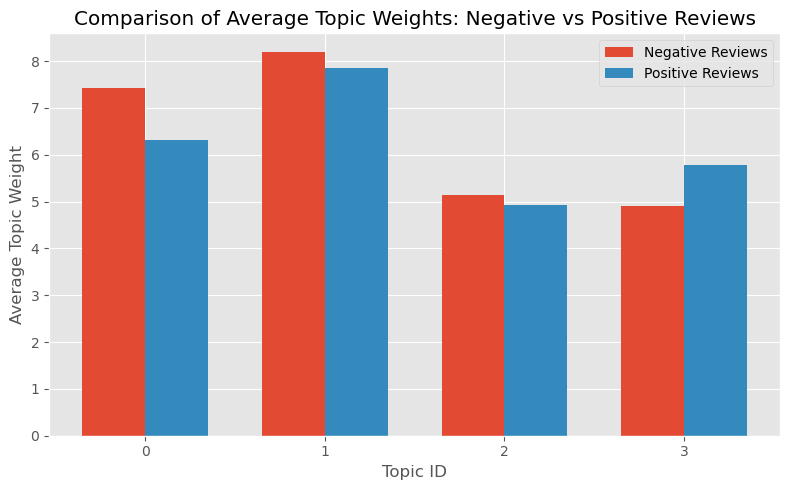

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# average topic weights for each topic ID 
avg_weights_neg = np.array([7.416, 8.182, 5.141, 4.912])
avg_weights_pos = np.array([6.312, 7.856, 4.932, 5.784])

topics = np.arange(len(avg_weights_neg))

# Plot a grouped bar chart
plt.figure(figsize=(8, 5))
bar_width = 0.35
# Plot negative review bars slightly to the left
plt.bar(topics - bar_width / 2, avg_weights_neg, bar_width, label="Negative Reviews")
# Plot positive review bars slightly to the right
plt.bar(topics + bar_width / 2, avg_weights_pos, bar_width, label="Positive Reviews")

plt.xlabel("Topic ID")
plt.ylabel("Average Topic Weight")
plt.title("Comparison of Average Topic Weights: Negative vs Positive Reviews")
plt.xticks(topics)
plt.legend()
plt.tight_layout()
plt.show()


# BerTopic

After completing the LDA-based topic modelling, we further explored a more advanced approach to uncover latent topics by using BerTopic. Unlike LDA, which relies on probabilistic topic-word distribution, BerTopic treats topic modelling as clustering task. It generates document embedding using pre-trained transformer-based language models, clusters these embeddings, and then extracts coherent topic reoresentations through a class-based variation of TF-IDF. This method has been shown to produce more coherent and semantically meaningful topics, making it competitive alternative to traditional topic modelling techniques. To keep the comparison consistent with the LDA experiments, we will still use a random sample of 1,000 negative reviews and 1,000 positive reviews.

In [30]:
# Step 1: Prepare Data (using the 'clean_text' column)

# 1.1 Extract the cleaned texts for each sentiment
positive_texts = sample_positive["clean_text"].tolist()  # 1,000 positive reviews
negative_texts = sample_negative["clean_text"].tolist()  # 1,000 negative reviews

# 1.2 Combine into one list for model input
all_texts = positive_texts + negative_texts

# 1.3 (Optional) Create labels for later visualization
labels = ["positive"] * len(positive_texts) + ["negative"] * len(negative_texts)

# 1.4 Check counts
print(f"Total texts: {len(all_texts)}, Positive: {len(positive_texts)}, Negative: {len(negative_texts)}")




Total texts: 2000, Positive: 1000, Negative: 1000


In [31]:
# ======================================
# Step 2: Generate BERT Embeddings
# ======================================

from sentence_transformers import SentenceTransformer

# 2.1 Load a lightweight pre‑trained sentence transformer
# We use 'all-MiniLM-L6-v2' for a good speed/quality trade‑off.
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")

# 2.2 Encode all texts into fixed‑length embeddings
# show_progress_bar=True 可以让你看到进度
embeddings = sentence_model.encode(
    all_texts, 
    show_progress_bar=True
)

# 2.3 Verify the shape of the embeddings array
# It should be (2000, embedding_dim), embedding_dim typically = 384 for MiniLM.
print("Embeddings shape:", embeddings.shape)


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Embeddings shape: (2000, 384)


In [32]:
# ======================================
# Step 3: Train the BERTopic Model
# ======================================

from bertopic import BERTopic

# 3.1 Initialize a BERTopic model.
# - calculate_probabilities=True will allow us to get per-document topic probabilities later.
# - verbose=True prints progress to the console.
topic_model = BERTopic(
    language="english",
    calculate_probabilities=True,
    verbose=True
)

# 3.2 Fit the model on our texts & embeddings
#   - all_texts: list of 2,000 review strings
#   - embeddings: NumPy array of shape (2000, 384)
topics, probs = topic_model.fit_transform(all_texts, embeddings)

# 3.3 Inspect the number of discovered topics (excluding the outlier topic “-1”)
num_topics = len(set(topics)) - (1 if -1 in topics else 0)
print(f"BERTopic discovered {num_topics} topics (with outliers as topic -1).")


2025-07-20 09:49:57,597 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-20 09:50:10,786 - BERTopic - Dimensionality - Completed ✓
2025-07-20 09:50:10,787 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-20 09:50:10,931 - BERTopic - Cluster - Completed ✓
2025-07-20 09:50:10,934 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-20 09:50:11,018 - BERTopic - Representation - Completed ✓


BERTopic discovered 5 topics (with outliers as topic -1).


### Generate Negative & Positive Review Distribution 

In [ ]:
# === Negative Reviews Topic Inference ===

# Extract negative texts
neg_texts = sample_negative["clean_text"].tolist()

# Step 2:Generate embeddings using the same BERT model
neg_embeddings = sentence_model.encode(neg_texts, show_progress_bar=True)

# Step 3: Perform inference with the topic model and embeddings
neg_topics, neg_probs = topic_model.transform(neg_texts, embeddings=neg_embeddings)

# Step 4: Save the results
import pandas as pd

negative_results = pd.DataFrame({
    "text": neg_texts,
    "topic": neg_topics,
    "probability": neg_probs.max(axis=1)
})

print("Negative Topics Distribution:")
print(negative_results["topic"].value_counts())



Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-07-20 10:12:01,678 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-07-20 10:12:07,649 - BERTopic - Dimensionality - Completed ✓
2025-07-20 10:12:07,650 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-07-20 10:12:07,680 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-07-20 10:12:07,751 - BERTopic - Probabilities - Completed ✓
2025-07-20 10:12:07,752 - BERTopic - Cluster - Completed ✓


Negative Topics Distribution:
topic
0    474
1    297
3    113
2    100
4     16
Name: count, dtype: int64


In [ ]:
# === Positive Reviews Topic Inference ===

pos_texts = sample_positive["clean_text"].tolist()

#embeddings
pos_embeddings = sentence_model.encode(pos_texts, show_progress_bar=True)

pos_topics, pos_probs = topic_model.transform(pos_texts, embeddings=pos_embeddings)

positive_results = pd.DataFrame({
    "text": pos_texts,
    "topic": pos_topics,
    "probability": pos_probs.max(axis=1)
})

print("\nPositive Topics Distribution:")
print(positive_results["topic"].value_counts())


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-07-20 10:12:19,840 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-07-20 10:12:22,870 - BERTopic - Dimensionality - Completed ✓
2025-07-20 10:12:22,871 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-07-20 10:12:22,908 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-07-20 10:12:22,992 - BERTopic - Probabilities - Completed ✓
2025-07-20 10:12:22,993 - BERTopic - Cluster - Completed ✓



Positive Topics Distribution:
topic
0    336
1    292
2    191
3    152
4     29
Name: count, dtype: int64


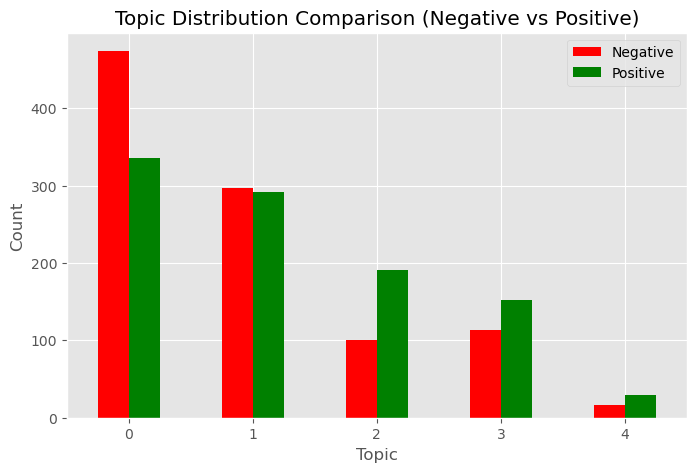

Topic 0: wa, product, one, work, great, use, would, time, get, good
Topic 1: book, read, wa, story, one, good, ha, like, author, reading
Topic 2: album, cd, song, music, like, track, one, sound, wa, good
Topic 3: movie, film, wa, one, dvd, great, see, watch, like, bad
Topic 4: game, fun, one, graphic, play, wa, like, good, first, playing


In [ ]:


# Combine into a single DataFrame for easier visualization
neg_topic_counts = negative_results["topic"].value_counts().sort_index()
pos_topic_counts = positive_results["topic"].value_counts().sort_index()

topic_compare = pd.DataFrame({
    "Negative": neg_topic_counts,
    "Positive": pos_topic_counts
}).fillna(0)  # Fill with 0 when a topic is missing in one category

# Plot comparative bar chart
topic_compare.plot(
    kind="bar",
    figsize=(8,5),
    title="Topic Distribution Comparison (Negative vs Positive)",
    color=["red", "green"]
)
plt.xlabel("Topic")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

# Print the top 10 keywords for each topic
for topic_id in sorted(topic_model.get_topics().keys()):
    if topic_id == -1:  # Skip outliers
        continue
    words = [w for w, _ in topic_model.get_topic(topic_id)]
    print(f"Topic {topic_id}: {', '.join(words)}")


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get the main topic for each negative review
neg_pred_topics = negative_results["topic"].values
neg_true_labels = np.zeros(len(neg_pred_topics))  # Negative = 0

# Get the main topic for each positive review
pos_pred_topics = positive_results["topic"].values
pos_true_labels = np.ones(len(pos_pred_topics))  # Positive = 1

#  Merge true labels and predicted labels
y_true = np.concatenate([neg_true_labels, pos_true_labels])
y_pred = np.concatenate([
    (neg_pred_topics >= 0).astype(int),  # Predict positive (1) if assigned a valid topic (>=0), else negative (0)
    (pos_pred_topics >= 0).astype(int)
])


In [48]:
# Visualize Topics (Intertopic Distance Map)
fig_topics = topic_model.visualize_topics()
fig_topics.show()


In [ ]:
# Visualize Documents using the original embeddings
fig_docs = topic_model.visualize_documents(
    all_texts,
    embeddings=embeddings,
    hide_document_hover=True  
)
fig_docs.show()


In [ ]:
from umap import UMAP

# First, reduce embeddings to 2D using UMAP
reduced_embeddings = UMAP(
    n_neighbors=10, 
    n_components=2, 
    min_dist=0.0, 
    metric="cosine"
).fit_transform(embeddings)

# Visualize the document distribution in the reduced space
fig_docs_reduced = topic_model.visualize_documents(
    all_texts,
    reduced_embeddings=reduced_embeddings,
    hide_document_hover=True
)
fig_docs_reduced.show()


In [ ]:
# Prepare custom hover labels for "Positive" and "Negative"
classes = ["positive"] * len(sample_positive) + ["negative"] * len(sample_negative)

fig_custom_hover = topic_model.visualize_documents(
    classes,                   # Use custom hover labels instead of titles
    reduced_embeddings=reduced_embeddings,
    hide_document_hover=False   # Enable document hover
)
fig_custom_hover.show()


In [53]:
# Visualize Topic Hierarchy (dendrogram)
fig_hierarchy = topic_model.visualize_hierarchy()
fig_hierarchy.show()


In [ ]:
# Compute hierarchical topic structure
hierarchical_topics = topic_model.hierarchical_topics(all_texts)

# Correct usage: pass hierarchical_topics as the first positional argument
topic_tree = topic_model.get_topic_tree(hierarchical_topics)

print(topic_tree)


100%|██████████| 4/4 [00:00<00:00, 254.35it/s]

.
├─■──game_fun_one_graphic_play ── Topic: 4
└─wa_book_one_great_good
     ├─book_wa_one_great_good
     │    ├─■──movie_film_wa_one_dvd ── Topic: 3
     │    └─book_wa_one_read_great
     │         ├─■──wa_product_one_work_great ── Topic: 0
     │         └─■──book_read_wa_story_one ── Topic: 1
     └─■──album_cd_song_music_like ── Topic: 2



In [56]:
# Visualize top-n terms per topic
fig_barchart = topic_model.visualize_barchart()
fig_barchart.show()


In [ ]:
# Visualize similarity heatmap 
fig_heatmap = topic_model.visualize_heatmap(n_clusters=4)
fig_heatmap.show()


In [59]:
# 查看所有话题中 term rank vs c-TF-IDF score
fig_termrank = topic_model.visualize_term_rank(log_scale=True)
fig_termrank.show()


In [ ]:
# Prepare class list aligned with all_texts
classes = ["positive"] * len(sample_positive) + ["negative"] * len(sample_negative)

# Compute topic distributions for each class
topics_per_class = topic_model.topics_per_class(
    all_texts, 
    classes=classes
)

# Visualization 
fig_per_class = topic_model.visualize_topics_per_class(topics_per_class)
fig_per_class.show()


2it [00:00, 22.71it/s]
